In [7]:
import asyncio
import websockets
import json
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply()
import warnings
import numpy as np
import datetime
from utils import collect_all_instruments_ids, collect_single_instrument_data
warnings.filterwarnings("ignore")

## Соберем все id-щники и опционы, которым они соответсвуют

In [8]:
# все id-шники
instruments_df = collect_all_instruments_ids()
instruments_df.head(5)

,instrument_name,instrument_id
0,BTC-24OCT22-15000-C,140131
1,BTC-24OCT22-15000-P,140132
2,BTC-24OCT22-16000-C,140133
3,BTC-24OCT22-16000-P,140134
4,BTC-24OCT22-17000-C,140136


## Собираем данные по конкретному опциону

In [9]:
# по конкретному опциону
single_option = collect_single_instrument_data(instrument_id = 140054, number_of_ticks = 100)
single_option.head(5)

2022-10-23 15:44:47.244 | INFO     | utils:call_api:68 - Collected 100 ticks for id = 140054


,instrument_name,timestamp,underlying_price,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp,strike
0,BTC-23OCT22-15000-C,1666512000014,19159.46,210.0,0.2171,0.0,0.0,2022-10-23 11:00:00.014000,15000


## Собираем по одному тику для каждого опциона, чтобы узнать все страйки и их рыночные волатильности

2022-10-23 16:13:02.639 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 130486
2022-10-23 16:13:03.055 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 130487
2022-10-23 16:13:03.462 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 130251
2022-10-23 16:13:03.891 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 130252
2022-10-23 16:13:04.385 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 131275
2022-10-23 16:13:04.779 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 131276
2022-10-23 16:13:05.230 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 131277
2022-10-23 16:13:05.645 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 131278
2022-10-23 16:13:06.076 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 124944
2022-10-23 16:13:06.474 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 125375
2022-10-23 16:13:06.893 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 131279

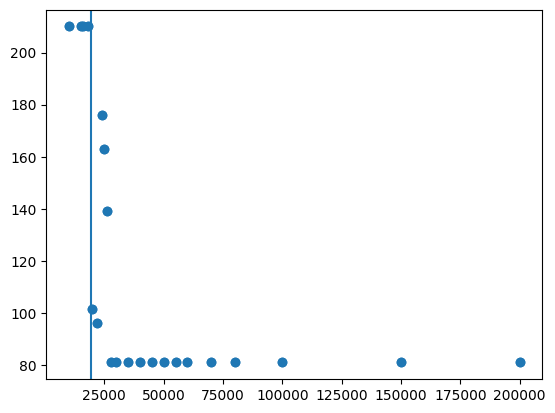

In [24]:
random_instrument = instruments_df.sample(1).iloc[0]["instrument_name"]
single_strike = instruments_df[
    (instruments_df["instrument_name"].str.startswith(random_instrument[0:11])) 
#     (instruments_df["instrument_name"].str.endswith(random_instrument[-1]))
]
single_strike_ids = single_strike.instrument_id.to_list()

options = pd.DataFrame(columns = single_option.columns.values)
for op_id in single_strike_ids:
    option = collect_single_instrument_data(instrument_id = op_id, number_of_ticks = 1)
    options = options.append(option)
    
plt.scatter(options["strike"], options["mark_iv"])
plt.axvline(x=option.iloc[0]["underlying_price"])
plt.show()

In [26]:
options.to_pickle(f"data/{options.iloc[0].instrument_name[:11]}.pkl")